## 1. Import packages

In [16]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [26]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)  
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_pred)),"\n"      


## 2. Data Preparation for LightGBM   

In [17]:
application_train = pd.read_csv('../Kaggle data/application_train.csv')

# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
application_train, categorical_feats, encoder_dict = label_encoder(application_train)
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET

## 3. LightGBM (with Bayesian Optimization)

### Step 1: Set parameters to be tuned

In [19]:
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'early_stopping_round':100, 'metric':'auc'}
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

### Step 2: Set the range for each parameter (make the range as narrow as possible)

In [20]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50)}, random_state=0)

### Step 3: Bayesian Optimization: Maximize

In [21]:
#lgbBO.maximize(init_points=init_round, n_iter=opt_round)

### Step 4: Get the parameters

In [22]:
# lgbBO.res['max']['max_params']

In [33]:
# ### Put all together
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight, max_bin):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['max_bin'] = int(round(max_bin))
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                           'max_bin': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [34]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)
print(opt_params)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_bin |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
    1 | 00m19s |    0.74696 |             0.9583 |             0.6167 |      4.8931 |      1.9198 |   21.1779 |      5.3476 |            32.7936 |           0.0272 |      35.5251 | 
    2 | 00m14s |    0.74820 |             0.9058 |             0.4501 |      3.9958 |      0.4301 |   24.6664 |      5.0807 |            32.5443 |           0.0776 |      39.0190 | 
    3 | 00m18s |    0.74917 |             0.9136 |             0.8134 |      2.3074 |      2.8340 |   36.3934 |      8.3222 |            32.7620 |           0.0462 |      36.6580 | 
    4 | 00m15s |    0.74904 |             0.9851 |             0.8709 |     

### Step 5: Apply tuned parameters to LightGBM

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.766917	valid_1's auc: 0.747011
[200]	training's auc: 0.788855	valid_1's auc: 0.753153
[300]	training's auc: 0.806074	valid_1's auc: 0.754272
[400]	training's auc: 0.820784	valid_1's auc: 0.754859
Early stopping, best iteration is:
[393]	training's auc: 0.81969	valid_1's auc: 0.754972
Accuracy:0.920
Classification report
             precision    recall  f1-score   support

          0       0.92      1.00      0.96     84807
          1       0.56      0.02      0.03      7447

avg / total       0.89      0.92      0.88     92254

Confusion matrix
[[84705   102]
 [ 7317   130]]
ROC AUC Score
0.5081269815320397
Feature importances: [219, 113, 135, 62, 49, 91, 210, 498, 324, 516, 92, 152, 187, 176, 118, 269, 414, 406, 317, 347, 327, 0, 36, 82, 2, 37, 15, 343, 131, 107, 141, 185, 230, 9, 10, 12, 72, 28, 31, 281, 499, 395, 419, 124, 161, 161, 136, 135, 84, 104, 127, 91, 167, 116, 134, 105, 174, 139, 170,

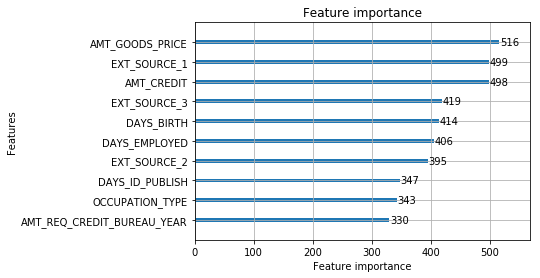

In [35]:
# Prepare dataset 
from sklearn import cross_validation
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

# LGBM with Bayesian Optimization
LGBM_bayes = LGBMClassifier(
    num_leaves=41,
    feature_fraction = 0.2804573216950702,
    bagging_fraction = 0.8606778717048246,
    max_depth=9,
    lambda_l1 = 0.12923438178409963,
    lambda_l2 = 0.097255485181867,
    min_split_gain=0.04783390506262965,
    min_child_weight=8,
    max_bin = 12,
    random_state=0, 
    n_estimators=100, 
    learning_rate=0.05,
    application = 'binary',
    num_iterations = 10000, 
    early_stopping_round = 100, 
    metric = 'auc'
  )



LGBM_bayes_fit = LGBM_bayes.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

# measure performance
LGBM_bayes_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_bayes, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True)

# feature importances
print('Feature importances:', list(LGBM_bayes.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_bayes_fit, max_num_features=10)
plt.show()

# 4. LightGBM (with Grid Search)

In [ ]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', learning_rate = 0.05, n_estimators = 100, random_state=0)

param_grid = {
    'num_leaves': [10,20,30,40], 
    'feature_fraction': [0.1,0.2,0.3],
    'bagging_fraction': [0.6,0.7,0.8],
    'max_depth':[5,10,15],
    'max_bin':[5,10,15],
    'lambda_l1':[0.1,0.2,0.3],
    'lambda_l2':[0.08,0.09,0.1],
    'min_split_gain':[0.03,0.04,0.05],
    'min_child_weight':[7,8,9]
}

LGBM_grid = GridSearchCV(estimator, param_grid)
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(objective = 'binary',
                                      learning_rate = 0.05, 
                                     n_estimators = 100, 
                                     random_state=0,
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                              bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              max_bin = LGBM_grid.best_params_['max_bin'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight'])
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=10)
plt.show()

Start training...


In [ ]:
# Submission file
application_test = pd.read_csv('../Kaggle data/application_test.csv')
test_df = label_encoder(application_test)[0]

#Bayes Optimization
out_bayes = pd.DataFrame({"SK_ID_CURR":test_df["SK_ID_CURR"], "TARGET":LGBM_bayes.predict_proba(test_df)[:,1]})
out_bayes.to_csv("submissions_toy_bayes.csv", index=False)

#Grid Search
out_grid = pd.DataFrame({"SK_ID_CURR":test_df["SK_ID_CURR"], "TARGET":LGBM_grid.predict_proba(test_df)[:,1]})
out_grid.to_csv("submissions_toy_grid.csv", index=False)